In [1]:
import tensorflow as tf
import pandapybullet as ppb
import pybullet
import autograd.numpy as np
from IPython.core import display
from autograd.scipy.linalg import sqrtm
from autograd import grad, jacobian,elementwise_grad
import tf_kdl as tk
import PyKDL
import tensorflow_probability as tfp
import tf_oc as oc
import matplotlib.pyplot as plt
from math import pi
from tf_quaternion import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

D:\Anaconda\envs\venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\envs\venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
plt.style.use("default")


In [4]:
dt = 1e-3
mode = "DIRECT"
# mode = "GUI"

In [5]:
world_sim = ppb.WorldSim(gravity=[0,0,-9.81], mode=mode)
world_sim.set_time_step(dt)
world_sim.setup_scene()

In [6]:
# For Panda
# table = world_sim.load_table()
robot = world_sim.load_panda(pos=[0.,0.,0.], orn=[0.,0.,0.])
## For others:
# robot = world_sim.add_robot({"urdf":"/robots/3dof_robot.urdf", "ee_index":3}, get_class=False)

In [7]:
def create_primitives(shapeType=2, rgbaColor=[1, 1, 0, 1], pos = [0, 0, 0], radius = 1, length = 2, halfExtents = [0.5, 0.5, 0.5], baseMass=0, basePosition = [0,0,0]):
    visualShapeId = pybullet.createVisualShape(shapeType=shapeType, rgbaColor=rgbaColor, visualFramePosition=pos, radius=radius, length=length, halfExtents = halfExtents)
    collisionShapeId = pybullet.createCollisionShape(shapeType=shapeType, collisionFramePosition=pos, radius=radius, height=length, halfExtents = halfExtents)
    bodyId = pybullet.createMultiBody(baseMass=baseMass,
                      baseInertialFramePosition=[0, 0, 0],
                      baseVisualShapeIndex=visualShapeId,
                      basePosition=basePosition,
                      useMaximalCoordinates=True)
    return visualShapeId, collisionShapeId, bodyId

In [8]:
is_simple = False
obs_ids = []
if is_simple:
    _,_,board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.02, 0.5, 0.3))
    pybullet.resetBasePositionAndOrientation(board_id, (0.6, 0., 0.6), (0,0,0,1))
    obs_ids = [board_id]
else:
    board_id = pybullet.loadURDF(world_sim.envs_path+"/objects/support.urdf", globalScaling=0.001)
    u = np.array([0,0,-np.pi/2])   
    theta = tf.linalg.norm(u)
    u = u/theta
    quat = utils.axis_angle2quats(u, theta)
    quat = ppb.utils.quat2format_scalar_last(quat)
    pybullet.resetBasePositionAndOrientation(board_id, (0.6,-2.2,-.6), quat)

    _,_,main_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.02, 0.7, 0.25))
    pybullet.resetBasePositionAndOrientation(main_board_id, (0.75, -0.1, 0.67), (0,0,0,1))
    obs_ids += [main_board_id]
    
    _,_,bottom_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.15, 0.7, 0.02))

    pybullet.resetBasePositionAndOrientation(bottom_board_id, (0.60, -0.1, 0.44), (0,0,0,1))
    obs_ids += [bottom_board_id]

    _,_,top_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.17, 0.7, 0.02))

    pybullet.resetBasePositionAndOrientation(top_board_id, (0.59, -0.1, 0.9), (0,0,0,1))
    obs_ids += [top_board_id]

    _,_,middle_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25))

    pybullet.resetBasePositionAndOrientation(middle_board_id, (0.59, -0.08, 0.67), (0,0,0,1))
    obs_ids += [middle_board_id]

    _,_,left_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25))

    pybullet.resetBasePositionAndOrientation(left_board_id, (0.59, 0.6, 0.67), (0,0,0,1))
    obs_ids += [left_board_id]

    _,_,right_board_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25))

    pybullet.resetBasePositionAndOrientation(right_board_id, (0.59, -0.75, 0.67), (0,0,0,1))
    obs_ids += [right_board_id]
        

In [9]:
targets = np.array([[ 0.55, -0.6 ,  0.55],
       [ 0.55, -0.6 ,  0.6 ],
       [ 0.55, -0.6 ,  0.65],
       [ 0.55, -0.6 ,  0.7 ],
       [ 0.55, -0.6 ,  0.75],
       [ 0.55, -0.6 ,  0.8 ],
       [ 0.55, -0.55,  0.55],
       [ 0.55, -0.55,  0.6 ],
       [ 0.55, -0.55,  0.65],
       [ 0.55, -0.55,  0.7 ],
       [ 0.55, -0.55,  0.75],
       [ 0.55, -0.55,  0.8 ],
       [ 0.55, -0.5 ,  0.55],
       [ 0.55, -0.5 ,  0.6 ],
       [ 0.55, -0.5 ,  0.65],
       [ 0.55, -0.5 ,  0.7 ],
       [ 0.55, -0.5 ,  0.75],
       [ 0.55, -0.5 ,  0.8 ],
       [ 0.55, -0.45,  0.55],
       [ 0.55, -0.45,  0.6 ],
       [ 0.55, -0.45,  0.65],
       [ 0.55, -0.45,  0.7 ],
       [ 0.55, -0.45,  0.75],
       [ 0.55, -0.45,  0.8 ],
       [ 0.55, -0.4 ,  0.55],
       [ 0.55, -0.4 ,  0.6 ],
       [ 0.55, -0.4 ,  0.65],
       [ 0.55, -0.4 ,  0.7 ],
       [ 0.55, -0.4 ,  0.75],
       [ 0.55, -0.4 ,  0.8 ],
       [ 0.55, -0.35,  0.55],
       [ 0.55, -0.35,  0.6 ],
       [ 0.55, -0.35,  0.65],
       [ 0.55, -0.35,  0.7 ],
       [ 0.55, -0.35,  0.75],
       [ 0.55, -0.35,  0.8 ],
       [ 0.55, -0.3 ,  0.55],
       [ 0.55, -0.3 ,  0.6 ],
       [ 0.55, -0.3 ,  0.65],
       [ 0.55, -0.3 ,  0.7 ],
       [ 0.55, -0.3 ,  0.75],
       [ 0.55, -0.3 ,  0.8 ],
       [ 0.55, -0.25,  0.55],
       [ 0.55, -0.25,  0.6 ],
       [ 0.55, -0.25,  0.65],
       [ 0.55, -0.25,  0.7 ],
       [ 0.55, -0.25,  0.75],
       [ 0.55, -0.25,  0.8 ],
       [ 0.55, -0.2 ,  0.55],
       [ 0.55, -0.2 ,  0.6 ],
       [ 0.55, -0.2 ,  0.65],
       [ 0.55, -0.2 ,  0.7 ],
       [ 0.55, -0.2 ,  0.75],
       [ 0.55, -0.2 ,  0.8 ],
       [ 0.55,  0.15,  0.55],
       [ 0.55,  0.15,  0.6 ],
       [ 0.55,  0.15,  0.65],
       [ 0.55,  0.15,  0.7 ],
       [ 0.55,  0.15,  0.75],
       [ 0.55,  0.15,  0.8 ],
       [ 0.55,  0.2 ,  0.55],
       [ 0.55,  0.2 ,  0.6 ],
       [ 0.55,  0.2 ,  0.65],
       [ 0.55,  0.2 ,  0.7 ],
       [ 0.55,  0.2 ,  0.75],
       [ 0.55,  0.2 ,  0.8 ],
       [ 0.55,  0.25,  0.55],
       [ 0.55,  0.25,  0.6 ],
       [ 0.55,  0.25,  0.65],
       [ 0.55,  0.25,  0.7 ],
       [ 0.55,  0.25,  0.75],
       [ 0.55,  0.25,  0.8 ],
       [ 0.55,  0.3 ,  0.55],
       [ 0.55,  0.3 ,  0.6 ],
       [ 0.55,  0.3 ,  0.65],
       [ 0.55,  0.3 ,  0.7 ],
       [ 0.55,  0.3 ,  0.75],
       [ 0.55,  0.3 ,  0.8 ],
       [ 0.55,  0.35,  0.55],
       [ 0.55,  0.35,  0.6 ],
       [ 0.55,  0.35,  0.65],
       [ 0.55,  0.35,  0.7 ],
       [ 0.55,  0.35,  0.75],
       [ 0.55,  0.35,  0.8 ],
       [ 0.55,  0.4 ,  0.55],
       [ 0.55,  0.4 ,  0.6 ],
       [ 0.55,  0.4 ,  0.65],
       [ 0.55,  0.4 ,  0.7 ],
       [ 0.55,  0.4 ,  0.75],
       [ 0.55,  0.4 ,  0.8 ]])

In [10]:
targets = targets[6:]

In [11]:
ys = np.array([-0.45, -0.25,  0.15,  0.35])
zs = np.arange(0.6, 0.81, 0.10)
x = 0.6
offset = -0.05
for i in range(targets.shape[0]):
    _,_,target_id = create_primitives(pybullet.GEOM_BOX, halfExtents=(0.03, 0.01, 0.01), rgbaColor=(1,0,0,1))
    pybullet.resetBasePositionAndOrientation(target_id, targets[i], (0,0,0,1))



In [12]:
urdf = tk.urdf_from_file(world_sim.envs_path + '/robots/frankaemika_new/panda_arm_kdl.urdf')
# urdf = tk.urdf_from_file(world_sim.envs_path + '/robots/3dof_robot.urdf')

chain = tk.tk_chain_from_urdf(urdf)
# chain_pykdl = tk.kdl_chain_from_urdf(urdf)
dyn = tk.ChainDynParam(chain)
# dyn_pykdl_mixed = tk.ChainDynParamPyKDL(chain_pykdl)

Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link0']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link1']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link2']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link4']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link5']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link6']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link7']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_hand']/collision[1]


In [13]:
# Transformation from world frame to robot base frame
# # For Panda on the table
# base_pos = tf.cast(np.array([-.5, -.4, 0.88])[None], tf.float32)
# base_rot_vec = np.array([0, 0, np.pi / 2])
# base_rot_mat = tf.cast(ppb.utils.rotvec2mat(base_rot_vec), tf.float32)
# base_rot_mat_inv = tf.cast(tf.transpose(base_rot_mat), tf.float32)

# For Panda on the floor and others
base_pos = tf.cast(np.array([0., 0., 0.])[None], tf.float32)
base_rot_vec = np.array([0., 0., 0.])
base_rot_mat = tf.cast(ppb.utils.rotvec2mat(base_rot_vec), tf.float32)
base_rot_mat_inv = tf.cast(tf.transpose(base_rot_mat), tf.float32)



def kdl2bullet_x(x):
    """
    param: x: [batch, 3] position in kdl (wrt robot base frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat, x) + base_pos

def bullet2kdl_x(x):
    """
    param: x: [batch, 3] position in bullet (wrt bullet world frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat_inv, x - base_pos)

def kdl2bullet_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in kdl (wrt robot base frame)
    """
    kdl_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    world_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat, kdl_end_rot_mat)
    return rot2quat(world_end_rot_mat)

def bullet2kdl_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in bullet (wrt bullet world frame)
    """
    world_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    kdl_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat_inv, world_end_rot_mat)
    return rot2quat(kdl_end_rot_mat)
        
def kdl2bullet_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix
    """
    return kdl2bullet_x(x[:, :3]), kdl2bullet_q(x[:, 3:])

def bullet2kdl_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix
    """
    return bullet2kdl_x(x[:, :3]), bullet2kdl_q(x[:, 3:])


### Some tests for e-e pose ofr 3dof robot

In [14]:
# robot.teaching_mode()

In [15]:
# plt.plot(tf.stack(chain.joint_limits), "o")
# plt.plot(robot.q, "kx")

In [16]:
# Find the equilibrium configuration given ee pose:
# dt = 0.05
# xd = tf.constant([0.1, 0., 1.]) # Point A in the paper
# qA = tf.constant([6.2831845, 5.364822 , 2.085435 ])
# xd = tf.constant([1., 0., 1.]) # Point B in the paper
# qB = tf.constant([6.2831855 , 0.25320533, 1.2857    ])
# panda
# q = tf.cast(robot.q[:chain.nb_joint], tf.float32)
# other
# q = tf.zeros(chain.nb_joint)
# chain.xs(q*0, layout=tk.FkLayout.x)[:, :3]

In [17]:
# for i in range(20):
#     xs = chain.xs(q, layout=tk.FkLayout.xm)[-1, :3]
#     tf.print(xs)
#     error = xd - xs
# #     tf.print(error)

#     J = chain.jacobian(q[None], layout=tk.FkLayout.x)[0]
#     dq = tf.linalg.matvec(tf.linalg.pinv(J), error) 
#     q += 10*dq*dt
#     q = q%(2*pi)
# #     q = tf.clip_by_value(q, tf.stack(chain.joint_limits)[:,0], tf.stack(chain.joint_limits)[:,1])
    
     

In [18]:
# for i in range(3): 
#     pybullet.resetJointState(robot, i, qB[i])

### End-pose cost

In [19]:
quats_xyz = Quaternion(create_unit_rotations(angle=pi/2))
# u = tf.constant([-np.pi/2, 0., 0.])
u = tf.constant([0.        , np.pi/2, 0. ])       
theta = tf.linalg.norm(u)
u = u/theta
mu = tf.cast(utils.axis_angle2quats(u, theta), tf.float32)[None]

mu_  = Quaternion(tf.tile(mu, (3,1)))
rot_mu =  mu_ * quats_xyz
u = Quaternion(rot_mu) - mu_
u = u/tf.linalg.norm(u, axis=-1)[:,None]
norms = tf.constant([1, 1e-5, 1e-5])
cov = tf.reduce_sum(tf.einsum('k,kij->kij', 
                                  norms,
                                  tf.einsum('ki, kj->kij',u,u)), axis=0)
cov += 1e-6 * tf.eye(4)

prec = tf.linalg.inv(cov)
mu_quat = mu[None]
def normalS3_log_prob(x):
    """
    x : [hole_nb, batch_nb, 4]
    Quaternion lognormal distribution
    """
    mu__ = Quaternion(tf.tile(mu_quat, (x.q.shape[0], x.q.shape[1], 1)))
    diff = x - mu__
    quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec,diff))
    return quad


cov_x = tf.linalg.diag([1e-3, 1e-3, 1e-3])
prec_x = tf.linalg.inv(cov_x)

def normal_log_prob_(mu_x):
    """
    mu_x : [hole_nb, 1, 3]
    """
    def normal_log_prob(x):
        """
        x: [hole_nb, batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec_x,diff))
        return quad
    return normal_log_prob

def normal_log_prob__(mu_x):
    """
    mu_x : [1, 3]
    """
    def normal_log_prob(x):
        """
        x: [batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('bi,bi->b',diff, tf.linalg.einsum('ij,bj->bi',prec_x,diff))
        return quad
    return normal_log_prob

In [20]:
# # Try orientation distribution
# x_ = robot.x
# q_ = q_sample(mu, cov)[0]
# robot.ik(x_, orn_des=q_, max_iter=3000)

### Joint limit costs

In [21]:
joint_limits = tf.stack(chain.joint_limits)
lower_limits = joint_limits[:,0][None, None]
upper_limits = joint_limits[:,1][None, None]
def plot_limits(q):
    plt.plot(joint_limits, "o")
    plt.plot(q, "kx")
    
mean_limits = tf.reduce_mean(joint_limits,-1)[None]
@tf.function
def cost_joint_limit(q):
#     return tf.reduce_sum(chain.joint_limit_cost(q),axis=-1)/7.
    rl = tf.math.minimum(q-lower_limits, 0)
    ru = tf.math.maximum(q-upper_limits, 0)
    return 0.5*(tf.linalg.einsum('hbi,hbi->hb',rl, rl) + tf.linalg.einsum('hbi,hbi->hb',ru, ru))
#     return 0.5*(tf.reduce_sum(rl*rl, -1) + tf.reduce_sum(ru*ru, -1))


In [22]:
# start_ = tf.random.uniform(shape=(12, 3, 7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1])

# cost_joint_limit(start_)

### Optimization with L-BFGS

We first get 50 different IK solutions for a rivet hole position using L-BFGS. Sometimes it cannot find a good solution, I just get a bigger batch and hope to get 50 solutions.

data = np.load('rivetting_data2.npy', allow_pickle=True)
targets

In [23]:
# start_ = tf.random.uniform(shape=(12, 3, 7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1])
# normal_log_prob_batch = normal_log_prob_(mu_x)


In [24]:
# q_vec = tf.reshape(start_, (12*3, start_.shape[2]))
# xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
# world_end_pos = tf.reshape(xs_[..., :3], (12, 3, 3))
# log_prob_batch = normal_log_prob_batch(world_end_pos)

# for i in range(12):
#     normal_log_prob_nonbatch = normal_log_prob__(mu_x[i])
#     nb = normal_log_prob_nonbatch(world_end_pos[i])
#     for j in range(3):
# #         tf.print(chain.xs(start_[i,j][None], layout=tk.FkLayout.xm)[0, -1, :3]- world_end_pos[i,j])
#         tf.print(nb[j], log_prob_batch[i,j])

In [25]:
batch = 1500
mu_x = tf.cast(targets, tf.float32)[:, None]
normal_log_prob = normal_log_prob_(mu_x)
hole_nb = targets.shape[0]
@tf.function
def cost_ik(q):
    """
    q: [hole_nb, batch_nb, nb_dof]
    """
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
#     xs_ = tf.reshape(xs_, (q.shape[0], q.shape[1], xs_.shape[-1]))
    
    # if robot base frame is changed:
#     world_end_pos, world_end_quats = kdl2bullet_xq(xs_)
#     else:kdl_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch, 3))
    

    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
        
    ee_pos_cost = -normal_log_prob(world_end_pos)
    ee_quat_cost = -normalS3_log_prob(Quaternion(world_end_quats))
    return ee_pos_cost +  ee_quat_cost*0.1 + cost_joint_limit(q)*1e3


In [26]:
start  = tf.Variable(
    tf.random.uniform(shape=(hole_nb, batch, 7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1]))

In [27]:
# # L-BFGS
# def loss_and_gradient(x):
#     return tfp.math.value_and_gradient(cost_ik, x)

# optim_results = tfp.optimizer.lbfgs_minimize(
#       loss_and_gradient,
#       initial_position=start,
#       num_correction_pairs=10,
#       tolerance=1e-5)

In [28]:
@tf.function
def cost():
    return cost_ik(start)
optimizer = tf.keras.optimizers.Adam(0.5)


In [29]:
# Stochastic Gradient Descent
for i in range(1000000):
    try :
        optimizer.minimize(cost,[start] )
        display.clear_output(wait=True)
        tf.print(cost())
    except KeyboardInterrupt:
        break

[[0.73083353 2.8962481 0.000778884161 ... 0.00470411731 150.845032 524.824341]
 [0.279598624 2.91961527 0.00768206129 ... 2.97506905 1.15664017 3.7469337]
 [1.93598413 78.9104462 5.0199194 ... 1.2261188 33.4419403 0.053748291]
 ...
 [0.0108656315 10.5599728 0.349217534 ... 0.0889642239 0.00306689483 76.0690536]
 [0.0340588763 0.00248976657 5.47715235 ... 0.000245769304 0.260828167 0.0032112198]
 [78.6700134 4.10384607 0.0148513382 ... 3.04040623 2.70112729 3.2840879]]


In [30]:
# good_q__ = optim_results.position
good_q__ = start

In [31]:
good_q_ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q_[i] = good_q__[i][cost_joint_limit(good_q__)[i] < 1e-2]
    max_nb = min(max_nb,good_q_[i].shape[0])
    
for i in range(hole_nb):
    good_q_[i] = good_q_[i][:max_nb]
    
good_q_ = tf.stack(good_q_)

In [32]:
good_q_.shape

TensorShape([84, 1267, 7])

In [33]:
i = 0 # rivet hole
j = 0 # configuration nb

In [34]:
i = 0


[[4.10150315e-05]]


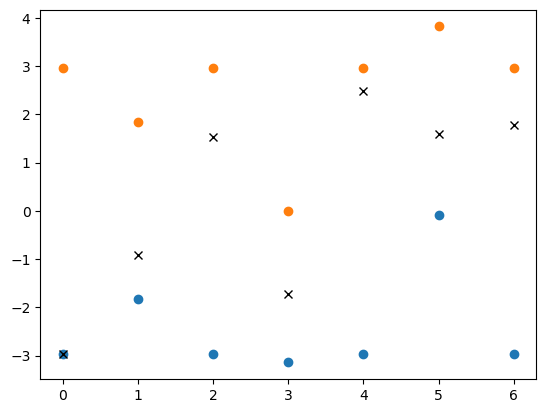

In [35]:
plot_limits(good_q_[i][j])
# robot.set_q_(good_q_[i][j])
tf.print(cost_joint_limit(good_q_[i][j][None]))
j+=1
# i+=1

In [36]:
def check_q(q):
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch , 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
    
    
    
    good_xs = [None for i in range(hole_nb)]
    good_xs_ind = [None for i in range(hole_nb)]
    max_nb = 1e5
    for i in range(hole_nb):
#         print(world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-2].shape)
        good_xs[i] = world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-1]
        good_xs_ind[i] = np.where(normal_log_prob(world_end_pos)[i] > -1e-1)
        max_nb = min(max_nb,good_xs[i].shape[0])

    for i in range(hole_nb):
        good_xs[i] = good_xs[i][:max_nb]

    good_xs = tf.stack(good_xs)
    return world_end_pos, good_xs, good_xs_ind
    

In [37]:
xs, good_xs, good_xs_ind = check_q(good_q_)
good_xs.shape

TensorShape([84, 514, 3])

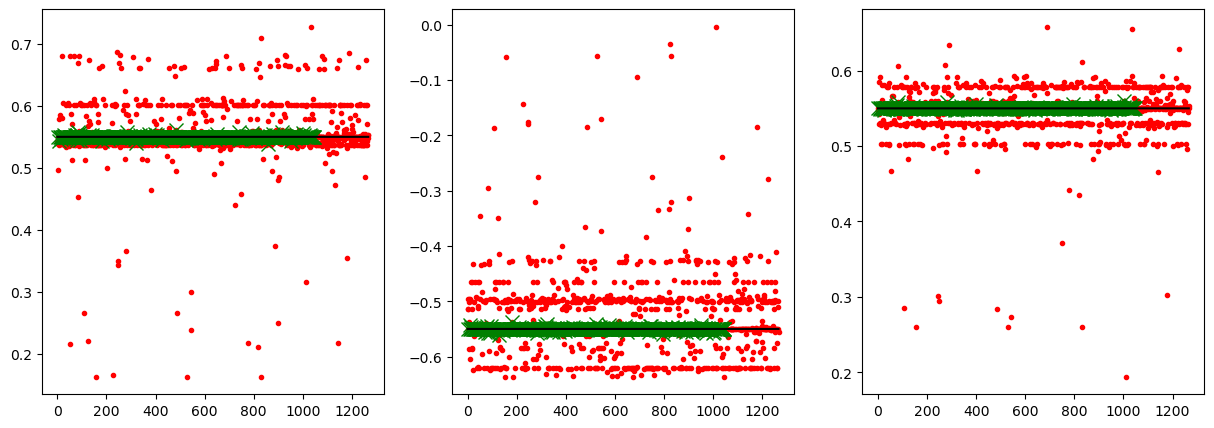

In [38]:
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
N = xs.shape[1]
j = 0 # choose a rivet hole
for i in range(3):
    ax[i].plot(range(N), xs[j, :,i], "r.")
    ax[i].plot(good_xs_ind[j][0][:good_xs.shape[1]], good_xs[j,:,i], "gx", ms=10)
    ax[i].plot(range(N), [mu_x[j,:,i]]*N, "k")

In [39]:
good_q = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q[i] = good_q_[i][-normal_log_prob(xs)[i] < 1e-1]
    max_nb = min(max_nb,good_q[i].shape[0])
    
for i in range(hole_nb):
    good_q[i] = good_q[i][:max_nb]
    
good_q = tf.stack(good_q)
good_q.shape

TensorShape([84, 514, 7])

In [40]:
i = 0
j = 1

[[0]]


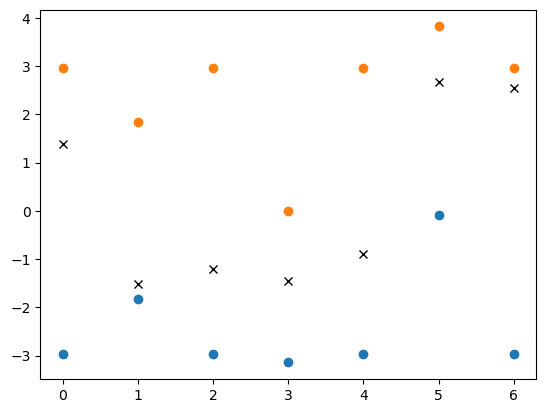

In [41]:
plot_limits(good_q[j,i])
# robot.set_q_(good_q[j,i])
tf.print(cost_joint_limit(good_q[j,i][None]))
i+=1

In [42]:
# check if there is any nan
tf.where(tf.math.is_nan(good_q) == True)

<tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>

### Displacement cost , new indices paper 2020

In [43]:
# Force: 
F = 150 # in Newton
nF = tf.constant([-1, 0., 0]) #direction of force in world frame coordinates

In [44]:
# For 7dof robot
K = tf.cast(robot.stiffness, tf.float32)[:chain.nb_joint, :chain.nb_joint]*10
C = tf.cast(robot.damping, tf.float32)[:chain.nb_joint, :chain.nb_joint] + tf.linalg.diag(tf.ones(7)*0.06)

# # ## For 3dof robot in the paper
# K = tf.linalg.diag([2.4*1e5, 1e5, 1e5])
# C = tf.linalg.diag([0.06, 0.06, 0.06])

f = tf.constant(66.) #Hz
w = tf.constant(2*pi*f)
w = tf.constant(150.)

def compute_H(w, M, J, C, K):
    """
    Finds the displacement force frequency response function H(w)
    """
    real = -(w**2)*M+K
    imag = w*C
    comp = tf.complex(real, imag)
#     inv = tf.linalg.inv(comp, adjoint=True)
    try:
        inv = tf.linalg.inv(comp, adjoint=True)
    except:
        r0  = tf.linalg.pinv(real) @ imag
        y11 = tf.linalg.pinv(imag @ r0 + real)
        y10 = -r0 @ y11

        inv = tf.cast(tf.complex(y11,y10), dtype =comp.dtype)
    return J@inv@tf.transpose(J, (0,2,1))

def displacement(q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec)
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        
        A = tf.transpose(H, perm=(0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)

        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

@tf.function
def displacement_(w, q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec)
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        A = tf.transpose(H, (0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)
        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return  tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

In [45]:
# data_nb = 100
# w = tf.cast(np.linspace(0, 200, data_nb), tf.float32)
# dispA = np.zeros(data_nb)
# dispB = np.zeros(data_nb)
# for i in range(data_nb):
#     dispA[i] = tf.reduce_max(displacement_(w[i], qA[None])[0])
#     dispB[i] = tf.reduce_max(displacement_(w[i], qB[None])[0])


In [46]:
# plt.plot(w,dispA, "k", label="Point A")
# plt.plot(w,dispB, "b",  label="Point B")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.legend()

In [47]:
good_q.shape

TensorShape([84, 514, 7])

In [51]:
data_nb = 500
config_nb = 500
w__ = 66*2*pi
w__ = 450
w_ = tf.cast(np.linspace(0, w__, data_nb), tf.float32)
disp = np.zeros((hole_nb, config_nb, data_nb))
disp_x = np.zeros((hole_nb, config_nb, data_nb, 3))
disp_x
q_random = tf.random.uniform(shape=(hole_nb, config_nb,7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1])
for i in range(data_nb):
#     d_ = displacement_(w_[i], good_q[:,:config_nb])
    d_ = displacement_(w_[i], q_random[:,:config_nb])
#     disp[:,:, i] = tf.reduce_max(displacement_(w_[i], q_random), -1)
#     disp[:,:, i] = tf.reduce_max(d_, -1)
    disp_x[:,:,i] = d_


In [52]:
# disp = tf.einsum('abci,i->abc',disp_x, tf.constant([1., 0., 0.]))
disp = tf.reduce_max(disp_x, -1)

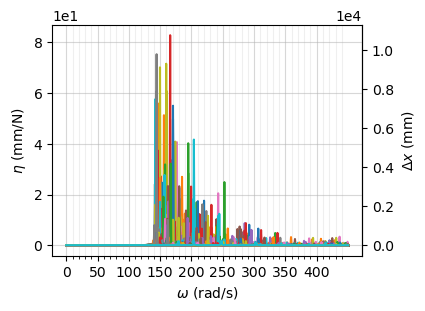

In [53]:
fig,ax = plt.subplots(1, figsize=(4,3))
for j in range(1):
    for i in range(config_nb):
        ax.plot(w_,disp[j,i]*1e3, "-", label="Point A")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('$\omega$'+' (rad/s)')
ax.set_ylabel('$\eta$'+' (mm/N)')
ax.grid("on")
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, w_[-1], 50)
minor_ticks = np.arange(0, w_[-1], 10)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

def forward(x):
    return x * 130.


def inverse(x):
    return x/130.

secax = ax.secondary_yaxis('right', functions=(forward, inverse))
secax.set_ylabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.set_facecolor("w")
# plt.legend()

In [54]:
tf.where(disp < 0.)

<tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>

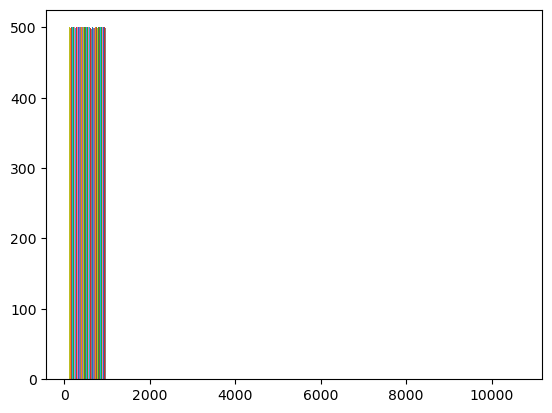

In [55]:
_ = plt.hist(disp[0]*1000*130.)

### Optimization for displacement

In [56]:
batch = 500
q_test = tf.Variable(good_q[:, :batch], trainable=True)
@tf.function
def cost_(): 
    return cost_ik(q_test)

In [57]:

@tf.function
def train_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(q_test)
        disp_cost = tf.norm(displacement(q_test),ord=2,axis=-1 )
        loss = cost_ik(q_test) + 1e1*disp_cost
        
    grads = tape.gradient(loss, [q_test])

#     J = chain.jacobian(q_test, layout=tk.FkLayout.xq)
#     Jv = J[:, :3]
#     Jv_pinv = tf.linalg.pinv(Jv)
    
#     Jw = J[:,3:]
#     Jw_ = tf.concat([tf.zeros((batch, 1, chain.nb_joint)), Jw],1)
#     Jq = 0.5*utils.omega_quat_left(kdl_q)@Jw_
#     Jq_pinv = tf.linalg.pinv(Jq)
    
#     dquat = world_q - mu_batch
#     dx = world_end_pos - mu_x
#     grads_ = grads[0] + 10*tf.linalg.matvec(Jq_pinv, dquat) + 100*tf.linalg.matvec(Jv_pinv, dx)
#     grads_ = tf.clip_by_value(grads[0], -1e15, 1e15)
    grads_ = grads[0]
    grads_ = tf.where(tf.math.is_nan(grads_), tf.zeros_like(grads_), grads_)
    optimizer.apply_gradients(zip([grads_], [q_test]))
    return loss, grads

In [58]:
optimizer = tf.keras.optimizers.Adam(0.05)

In [105]:
for i in range(1000000):
    try :
        loss, grads = train_step()
        display.clear_output(wait=True)
        tf.print(loss)
    except KeyboardInterrupt:
        break

[[0.00163814449 0.00165756687 0.0229394641 ... 0.00223494461 0.00444937637 0.0220892038]
 [0.0185449272 0.00369125186 0.00154372258 ... 0.0194793716 0.00396364927 0.0187286064]
 [0.00362362759 0.0139812538 0.00782355666 ... 0.00179088872 0.00458873063 0.00444711559]
 ...
 [0.00717568491 0.153614476 0.00207277271 ... 0.103289902 0.00270205969 0.00142017857]
 [0.00376762683 0.00813917071 0.00277020386 ... 0.0222838968 0.0692850128 0.258859754]
 [0.0201233886 0.0362072401 0.00387115404 ... 0.0157053862 0.0978342667 0.0220157802]]


In [106]:
# check if there is any nan
tf.where(tf.math.is_nan(loss) == True)

<tf.Tensor: shape=(0, 2), dtype=int64, numpy=array([], shape=(0, 2), dtype=int64)>

In [107]:
xs_,_,_ = check_q(q_test)
print(xs_.shape)
i=0

(84, 500, 3)


In [108]:
j = 0

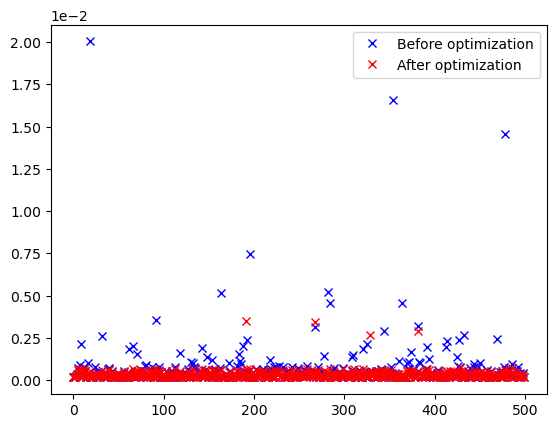

In [109]:
plt.plot(tf.linalg.norm(displacement(good_q[j,:batch][None])[0],axis=-1), "bx", label="Before optimization")
plt.plot(tf.linalg.norm(displacement(q_test[j][None])[0],axis=-1), "rx", label="After optimization")
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
j+=1
# do with 3 different w values

In [110]:
(displacement(good_q[:,:batch])*1e3).numpy()[...,0].flatten().shape

(42000,)

[]

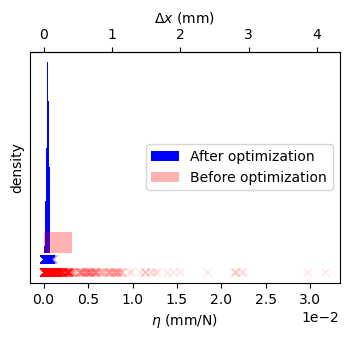

In [111]:
fig,ax=plt.subplots(1,figsize=(4,3))
density = 1
after_opt_data = displacement(q_test)*1e3
before_opt_data = displacement(good_q[:,:batch])*1e3
# ax.hist(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten(), density=density, color="b", label="After optimization")
# ax.hist(tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), density=density, alpha=0.3, color="r", label="Before optimization")
# ax.plot(after_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.1), "bx", alpha=0.1)
# ax.plot(before_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.2), "rx", alpha=0.1)

ax.hist(after_opt_data.numpy()[...,0].flatten(),density=density,color="b", label="After optimization")
ax.hist(before_opt_data.numpy()[...,0].flatten(), color="r",density=density, alpha=0.3, label="Before optimization")
ax.plot(after_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-100), "bx", alpha=0.1)
ax.plot(before_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-300), "rx", alpha=0.1)



ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel('$\eta$'+' (mm/N)')
ax.set_ylabel("density")
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.legend(loc=7)

ax.set_yticks([])

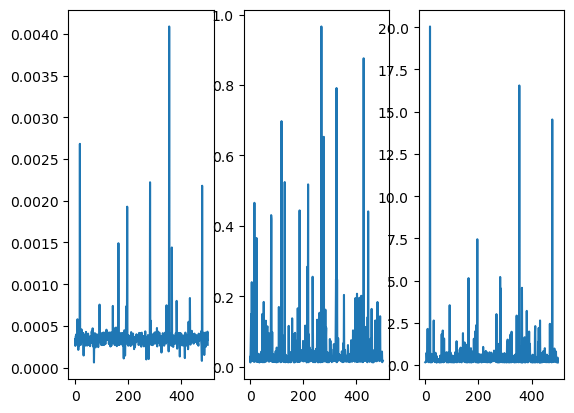

In [112]:
fig,ax = plt.subplots(ncols=3)
j = 0
for i in range(3):
    ax[i].plot(before_opt_data.numpy()[j,:,i])

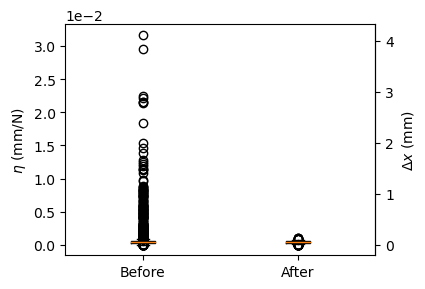

In [118]:
fig,ax = plt.subplots(figsize=(4,3))
density = 1
after_opt_data = displacement(q_test)*1e3
before_opt_data = displacement(good_q[:,:batch])*1e3

ax.boxplot([ before_opt_data.numpy()[...,0].flatten(), after_opt_data.numpy()[...,0].flatten()])

# ax.boxplot([tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), 
#             tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten()])

# ax.boxplot(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten())
ticks = ["Before", "After"]
ax.set_xticks([1,2])
ax.set_xticklabels( ticks, rotation=0 )
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel('$\eta$'+' (mm/N)')

secax = ax.secondary_yaxis('right', functions=(forward, inverse))
secax.set_ylabel('$\Delta x$'+' (mm)')
secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [116]:
print(np.std(after_opt_data.numpy()[...,0].flatten()))
np.mean(after_opt_data.numpy()[...,0].flatten())

0.00013112971


0.00040834103

In [117]:
print(np.std(before_opt_data.numpy()[...,0].flatten()))
np.mean(before_opt_data.numpy()[...,0].flatten())

0.00048334175


0.00043539485

In [133]:
data_teguh = {}
data_teguh = {"targets": targets, "q":q_test.numpy(), "disp":displacement(q_test).numpy()}

In [134]:
np.save("data2teguh", data_teguh)

In [ ]:
# i = 0

In [ ]:
# plot_limits(q_test[i])
# robot.set_q_(q_test[i])
# tf.print(cost_joint_limit(q_test[i][None]))
# i+=1

### Fatigue cost

In [ ]:
r = tf.ones(7)*0.12 # radius of the joint shaft
l = tf.ones(7)*0.182 # length of the joint shaft
G = 10. # joint shaft shear modulus
ka = 0.93*tf.ones(7)
kb = 0.86*tf.ones(7)
kc = 0.59*tf.ones(7)
kd = 1.*tf.ones(7)
ke = 0.753*tf.ones(7)
kf = 1.*tf.ones(7)
Se_ = 92.4*tf.ones(7) # in MPa ( N/m^2)
Se = ka*kb*kc*kd*ke*kf*Se_ # in MPa ( N/m^2)
F_ = tf.cast(F*nF, tf.float32)
F_ = tf.complex(F_, tf.zeros_like(F_))[None, None]
def compute_H_(w, M, J, C, K):
    """
    Finds the displacement force frequency response function H(w)
    """
    comp = tf.complex(-(w**2)*M+K, w*C)
    return tf.linalg.inv(comp, adjoint=True)@tf.transpose(J, (0,2,1))

def fatigue_cost(q):
    """
    Inequality cost, -endurance limit < torsional stress < endurance limit
    Either take abs value of torsional stress (it comes with the vector, that's why negative), or do as above.
    H: (-(w^2)M + jwC + K)^(-1)(J.T)
    """
    q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
    M = dyn.inertia_matrix(q_vec)
    J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
    J = tf.complex(J, tf.zeros_like(J))
    H = compute_H_(w, M, J, C, K)
    delta_q = tf.linalg.matvec(H , F_)
    gamma = tf.math.real(delta_q) * r /l # shear strain
    stress = G*gamma # torsional stress
#     return -ds.Normal(-Se, std).log_cdf(stress) - ds.Normal(-Se, std).log_cdf(-stress)

    rl = tf.math.minimum(stress-(-Se), 0)
    ru = tf.math.maximum(stress-(Se), 0)
    return 0.5*(tf.linalg.einsum('hbi,hbi->hb',rl, rl) + tf.linalg.einsum('hbi,hbi->hb',ru, ru))
    

In [ ]:
plt.plot(fatigue_cost(
    tf.random.uniform(shape=(hole_nb, batch, 7), minval=joint_limits[:,0],maxval=joint_limits[:,1]))[0], "kx")

### Variational Inference Part


In [ ]:
# @tf.function
def p(q):
    xs = chain.xs(q, layout=tk.FkLayout.xm)
    kdl_end_pos = xs[:, -1, :3]
    world_end_pos = tf.einsum('ij, aj->ai',base_rot_mat, kdl_end_pos) + base_pos

    kdl_end_rot_mat = tf.reshape(xs[:, -1, 3:], (q.shape[0], 3,3))
    world_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat, kdl_end_rot_mat)
    world_end_quats = rot2quat(world_end_rot_mat)
    
#     disp_cost = tf.reduce_max(displacement(q), axis=-1)
    disp_cost = tf.norm(displacement(q), ord=2, axis=-1)
    ee_pos_cost = -normal_log_prob(world_end_pos)
    ee_quat_cost = -normalS3_log_prob(Quaternion(world_end_quats))
#     return -ee_quat_cost
    return -ee_pos_cost - ee_quat_cost
#     return -ee_pos_cost - ee_quat_cost + reward_joint_limit(q)
#     return -disp_cost - ee_pos_cost - ee_quat_cost + reward_joint_limit(q)


### Define the cost function for variational inference

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)

In [ ]:
## q is GMM with means and covariances to learn
K = 5
log_priors_gmm = tf.Variable(tf.ones(K), trainable=True)
locs_gmm = tf.Variable(tf.random.normal(shape=(K,7)), trainable=True) # better start with the good solutions, this is a very bad guess
total_param_dims = 7*8//2
total_params =  tf.Variable(0.01*tf.ones((K,total_param_dims)), trainable=True)
# diag_params = tf.Variable(2*tf.ones((K,7)), trainable=True)

In [ ]:
@tf.function
def cost():
    triu = tfp.math.fill_triangular(total_params) # lower
    diag_part = tf.nn.softmax(tf.linalg.diag_part(triu)) + 1e-2
    triu = triu - tf.linalg.diag(tf.linalg.diag_part(triu)) + tf.linalg.diag(diag_part)
    cov_gmm = tf.linalg.matmul(triu, triu, transpose_b=True)

    q = oc.stats.GMMFull(oc.utils.log_normalize(log_priors_gmm), locs_gmm,cov_gmm)
#     cov_gmm = tf.linalg.diag(diag_params)
#     q = oc.stats.GMMFull(oc.utils.log_normalize(log_priors_gmm), locs_gmm,cov_gmm*cov_gmm)
    
    return q.kl_qp(p, temp=1., samples_size=50)

In [ ]:
optimizer.rate = 0.005
for i in range(1000000):
    try :
#         optimizer.minimize(cost, [locs_gmm,diag_params]) #first run this a bit to find the modes
#         optimizer.minimize(cost, [log_priors_gmm,locs_gmm,diag_params]) # then run this to give priorities to modes withhigher ucnertainties

        optimizer.minimize(cost, [locs_gmm]) #first run this a bit to find the modes
#         optimizer.minimize(cost, [locs_gmm,total_params]) #first run this a bit to find the modes
#         optimizer.minimize(cost, [log_priors_gmm,locs_gmm,total_params]) # then run this to give priorities to modes with
        loss = cost()
#         loss, grads = train_step(optimizer)
        display.clear_output(wait=True)
        tf.print(loss)
#         tf.print(reward_joint_limit(locs_gmm))
    except KeyboardInterrupt:
        break

In [ ]:
triu = tfp.math.fill_triangular(total_params) # lower
diag_part = tf.nn.softmax(tf.linalg.diag_part(triu)) + 1e-3
triu = triu - tf.linalg.diag(tf.linalg.diag_part(triu)) + tf.linalg.diag(diag_part)
cov_gmm = tf.linalg.matmul(triu, triu, transpose_b=True)
q = oc.stats.GMMFull(oc.utils.log_normalize(log_priors_gmm), locs_gmm,cov_gmm)

In [ ]:
i = 0

In [ ]:
robot.teaching_mode()

In [ ]:
robot.q_control(q.locs[i].numpy(), max_iter=5000)
tf.print(q.locs[i])
tf.print(robot.q)
tf.print(robot.x)
xs = chain.xs(q.locs[i][None], layout=tk.FkLayout.xm)
kdl_end_pos = xs[:, -1, :3]
tf.print(tf.einsum('ij, aj->ai',base_rot_mat, kdl_end_pos) + base_pos)
i+=1